<a href="https://colab.research.google.com/github/bishair/Model/blob/main/Model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import files
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [2]:
#Function to determine if the user uploaded csv or xlsx file format
def load_data(file_name):
    # Determine the file extension
    file_extension = os.path.splitext(file_name)[1]
    # Load data based on file extension
    if file_extension == '.xlsx':
        return pd.read_excel(file_name)
    elif file_extension == '.csv':
        return pd.read_csv(file_name)
    else:
        raise ValueError("Unsupported file type. Please upload an Excel or CSV file.")

#Function that returns the index of the row where the header is located based on the provided keywords
def find_header_row(file_name, keywords):
    # Load only the first 10 rows of the file for efficiency
    data = load_data(file_name).head(10)
    # Iterate over the rows to find the header row
    for row_index, row in data.iterrows():
        # Iterate over each cell in the row. For each cell iterate over each keyword in keywords. Covert each cell to string and to lowercase for efficiency
        if any(keyword.lower() in str(cell).lower() for cell in row for keyword in keywords):
            # Return the index of the header row
            return row_index
    # If no header row is found, return None
    return None

#Function to determine which columns contain the data on GW level, date and river water level
def find_columns_by_keyword(dataframe, keywords):
    matched_columns = []
    for column in dataframe.columns:
        # Ensure the column name is a string before calling .lower()
        column_str = str(column)
        if any(keyword.lower() in column_str.lower() for keyword in keywords):
            matched_columns.append(column)
    return matched_columns

In [3]:
# Upload the original file
uploaded = files.upload()
#In case user upload more than one file, only take the name of the first file
file_name = next(iter(uploaded))

Saving data of 2014.xlsx to data of 2014.xlsx


In [71]:
# Keywords to look for in the header row  =>  MODIFYY LATER DEPENDING UPON SAMPLE
header_keywords = ["date", "max", "min", "G21"]
data_keywords = ["date", "river", "water", "level", "groundwater", "G"]

In [72]:
# Find the header row
header_row = find_header_row(file_name, header_keywords)

# Check if the header row was found
if header_row is None:
    raise ValueError("Could not identify the header row. Please check the file format.")

# Load the data with the correct header row
data = load_data(file_name)
if header_row is not None:
    data.columns = data.iloc[header_row]
    data = data.drop(data.index[0:header_row+1]).reset_index(drop=True)  #Remove all the rows above the header

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [73]:
# Identify columns based on the keywords
date_columns = find_columns_by_keyword(data, ["date", "time"])
river_level_columns = find_columns_by_keyword(data, ["river", "water", "level", "max", "min"])
groundwater_level_columns = find_columns_by_keyword(data, ["groundwater", "G"])


In [74]:
# Check if we found exactly one column for each
if len(date_columns) != 1 or len(river_level_columns) < 2 or len(groundwater_level_columns) == 0:
    raise ValueError("Could not uniquely identify required columns. Please check the file format.")

# Extract the relevant columns
date_column = date_columns[0]
river_water_level_max = data[river_level_columns[0]].astype(float)  # Assuming first max
river_water_level_min = data[river_level_columns[1]].astype(float)  # Assuming second min
groundwater_level = data[groundwater_level_columns[0]].astype(float)  # Assuming first groundwater column  (MODDIFY LATER)

# Calculate the average river water level
river_water_level_avg = (river_water_level_max + river_water_level_min) / 2

# Handle missing values (if any) by forward filling
river_water_level_avg.fillna(method='ffill', inplace=True)
groundwater_level.fillna(method='ffill', inplace=True)

# Create a DataFrame with the preprocessed data
preprocessed_data = pd.DataFrame({
    'Date': pd.to_datetime(data[date_column]),
    'River_Water_Level_Avg': river_water_level_avg,
    'Groundwater_Level': groundwater_level
})

# Export the preprocessed data to a new Excel file
preprocessed_file_name = 'preprocessed_data_with_dates.xlsx'
preprocessed_data.to_excel(preprocessed_file_name, index=False)

# Download the preprocessed data file
files.download(preprocessed_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:

#Load the pre-processed data
data = pd.read_excel('preprocessed_data_with_dates.xlsx')

# Select the river water level as input and groundwater level as output
input_data = data['River_Water_Level_Avg'].values.reshape(-1, 1)
output_data = data['Groundwater_Level'].values

In [76]:
#Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_input_data = scaler.fit_transform(input_data)


In [94]:

#Create sequence for LSTM input
def create_sequences(input_data, output_data, time_steps):
    X, y = [], []
    for i in range(len(input_data) - time_steps):
        X.append(input_data[i:(i + time_steps)])
        y.append(output_data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 1  #Time steps for prediction
X, y = create_sequences(scaled_input_data, output_data, time_steps)

In [95]:
split = int(0.8 * len(X))  # 80% of data for training, 20% for testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [96]:
#LSTM Model
# Initialize the RNN
model = Sequential()

# Add the LSTM layer
model.add(LSTM(units=10, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(units=10))
model.add(Dense(1))

# Compile the RNN
model.compile(optimizer='adam', loss='mean_squared_error')


In [100]:

#Train the model
model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/300
4/4 [==============================] - 0s 50ms/step - loss: 10380.0703 - val_loss: 10476.3115
Epoch 2/300
4/4 [==============================] - 0s 23ms/step - loss: 10363.9092 - val_loss: 10461.2432
Epoch 3/300
4/4 [==============================] - 0s 26ms/step - loss: 10348.0381 - val_loss: 10446.3955
Epoch 4/300
4/4 [==============================] - 0s 26ms/step - loss: 10332.4111 - val_loss: 10431.7568
Epoch 5/300
4/4 [==============================] - 0s 33ms/step - loss: 10316.9766 - val_loss: 10417.3389
Epoch 6/300
4/4 [==============================] - 0s 39ms/step - loss: 10301.7568 - val_loss: 10403.1270
Epoch 7/300
4/4 [==============================] - 0s 21ms/step - loss: 10286.7930 - val_loss: 10389.0977
Epoch 8/300
4/4 [==============================] - 0s 58ms/step - loss: 10271.9551 - val_loss: 10375.2568
Epoch 9/300
4/4 [==============================] - 0s 52ms/step - loss: 10257.3311 - val_loss: 10361.5889
Epoch 10/300
4/4 [============================

In [101]:

# Make predictions
predicted_groundwater_level = model.predict(X_test)

# If you've scaled the data, you need to reverse the scaling to interpret the predictions
predicted_groundwater_level = scaler.inverse_transform(predicted_groundwater_level)

# Evaluate the model
mse = mean_squared_error(y_test, predicted_groundwater_level)
print(f"Mean Squared Error: {mse}")



1/1 [==============================] - 0s 22ms/step
Mean Squared Error: 1426.9684682209772


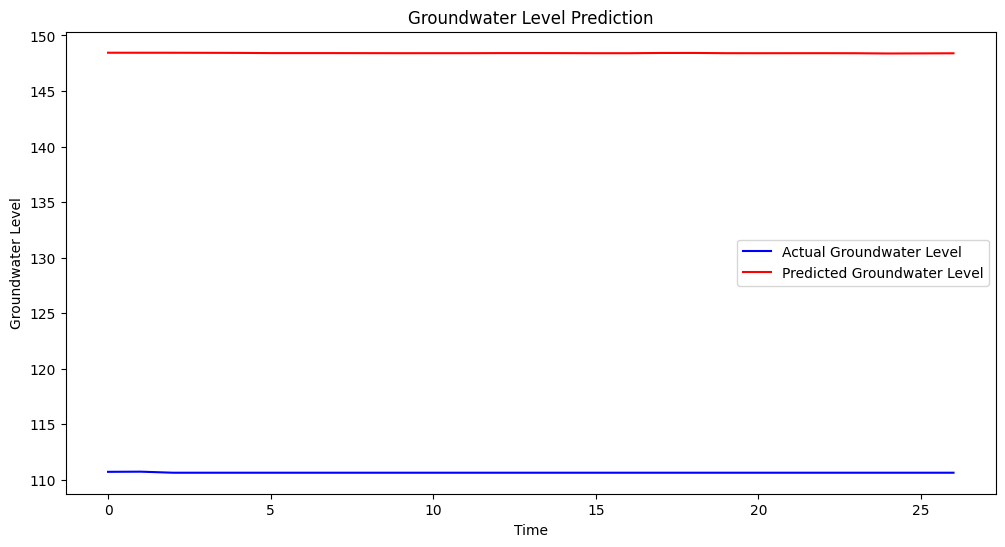

In [102]:

# Plot actual groundwater levels
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Groundwater Level', color='blue')

# Plot predicted groundwater levels
plt.plot(predicted_groundwater_level, label='Predicted Groundwater Level', color='red')

plt.xlabel('Time')
plt.ylabel('Groundwater Level')
plt.legend()
plt.title('Groundwater Level Prediction')

plt.show()